<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Deterministic Creation of Multi-Qubit W State Systems

## _*Benchmarking Competing Algorithms by Quantum Tomography*_ 


***
### Contributors
Pierre Decoodt


A generalized $n$-qubit W state system can be written as$^{[1]}$:
$$ |W_{n}\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: +...+ |00...1\rangle \:) $$

A specific compact algorithm allows the deterministic creation of W states of any size $n$., as described here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/community/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

This algorithm is inspired by Diker's theoretical proposition$^{[2]}$, but is characterized by a linear rather than quadratic progression of the number of gates needed when  $ n $ increases.

In many cases, the QISKit compiler is so smart that it allows safely the programming of circuits without taking into account the architecture of the different final real target devices. This is the approach that is presented here with realization of a compact multi-qubit W state generation program.

For the creation of such states, an other approach is to use a general algorithm of arbitrary initialization, as described _at the end_ of the following tutorial:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/using_different_gates.ipynb


Therefore, why worry about using a specific algorithm, sophisticated on the theoretical level, while a ready-made alternative, valid for any entangled state, is at our disposal?

For this reason, it seemed interesting to compare the two approaches by using quantum fidelity as a benchmark, with the help of the methodology presented here:

https://nbviewer.jupyter.org/github/Qiskit/qiskit-tutorial/blob/master/qiskit/ignis/state_tomography.ipynb (the code to calculate the quantum fidelity used here comes mostly from this last tutorial).

As you will see at the end of the notebook in the "results" section, one of the algorithms in competition clearly outperforms the other...

In [1]:
#Import packages

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, compile
from qiskit.converters import qobj_to_circuits
from qiskit import Aer, IBMQ

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram        
from qiskit.tools.qi.qi import state_fidelity, outer
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

In [2]:
# You may skip this if you don't have a credential. It will work locally on simulators from Aer
IBMQ.load_accounts()

In [3]:
IBMQ.backends() #for info

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [4]:
# You may skip this if you want
for backend in IBMQ.backends():
    print(backend.status())

BackendStatus(backend_name='ibmqx4', backend_version='1.0.0', operational=True, pending_jobs=111, status_msg='active')
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='1.0.0', operational=True, pending_jobs=2, status_msg='active')
BackendStatus(backend_name='ibmq_qasm_simulator', backend_version='0.1.547', operational=True, pending_jobs=0, status_msg='active')


In [5]:
Aer.backends() #for info

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

In [6]:
# Determine the job
n = int(input("type number of qubits + enter: "))

# create a n-qubit quantum register
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
my_state = QuantumCircuit(qr, cr, name='my_state')

# desired vector for a n-qubit W state
desired_vector = []
qr_vector = []
n_vector = 2**n
for i in range(n_vector):
        desired_vector.append(0)
for j in range(n) :           
        desired_vector[2**j] = 1/np.sqrt(n)

        
# choice of the circuit building method (arbitrary or specific)        
print("Do you want to use the specific method?")
W_state_circuit = input("    Answer by (y/n) + enter\n").upper()

if (W_state_circuit == "N") :
# Initialize a n-qubit W quantum state using the arbitrary method   
    for j in range(n) :                   
        qr_vector.append(qr[j])
    my_state.initialize(desired_vector, qr_vector)
    
else:
# Quantum circuit to make a n-qubit W state using the specific method
    my_state.x(qr[n-1]) #start is |10...0>
    for i in range(1,n) :
        theta = np.arccos(np.sqrt(1/(n-i+1)))
        my_state.ry(-theta,qr[n-i-1])       
        my_state.cz(qr[n-i],qr[n-i-1])
        my_state.ry(theta,qr[n-i-1])
    for i in range(1,n) :
        my_state.cx(qr[n-i-1],qr[n-i])

type number of qubits + enter: 4
Do you want to use the specific method?
    Answer by (y/n) + enter
y


In [7]:
# Test circuit "my_state"  : Measurements
measuring = QuantumCircuit(qr, cr, name='measuring')
for i in range(n) :
    measuring.measure(qr[i] , cr[i])
test = my_state+measuring

In [8]:
# Test circuit "my_state" : Local simulator
backend_sim = Aer.get_backend('qasm_simulator')
shots = 1024
job = execute(test, backend_sim, shots=shots, max_credits=5)
print(job.result().get_counts(test))

{'0001': 256, '1000': 256, '0100': 253, '0010': 259}


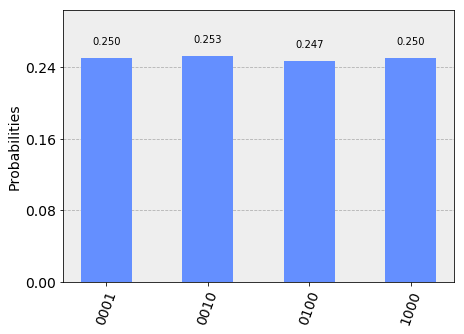

In [9]:
plot_histogram(job.result().get_counts(test))

In [10]:
# QASM from test
QASM_source = test.qasm()
print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q0[4];
creg c0[4];
x q0[3];
ry(-1.04719755119660) q0[2];
cz q0[3],q0[2];
ry(1.04719755119660) q0[2];
ry(-0.955316618124509) q0[1];
cz q0[2],q0[1];
ry(0.955316618124509) q0[1];
ry(-0.785398163397448) q0[0];
cz q0[1],q0[0];
ry(0.785398163397448) q0[0];
cx q0[2],q0[3];
cx q0[1],q0[2];
cx q0[0],q0[1];
measure q0[0] -> c0[0];
measure q0[1] -> c0[1];
measure q0[2] -> c0[2];
measure q0[3] -> c0[3];



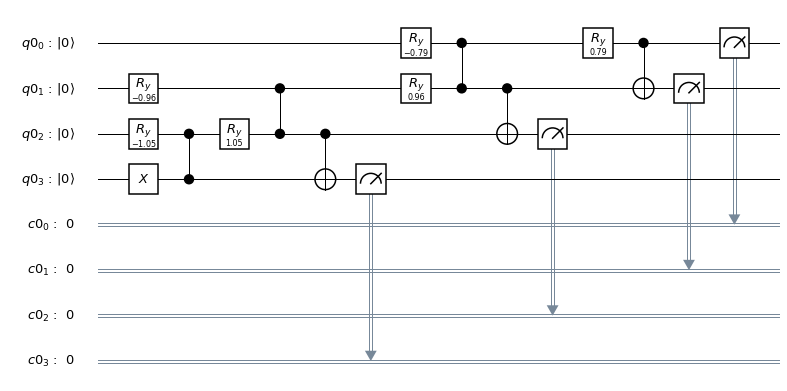

In [11]:
# Draw the circuit 
test.draw(output='mpl')

In [12]:
# Test circuit "my_state" : Real Quantum Computer (You may skip this if necessary)

# choose the backend
backend_IBMQ = least_busy(IBMQ.backends(operational=True, simulator=False))
shots = 1024

job = execute(test, backend_IBMQ, shots=shots, max_credits=5)
job_monitor(job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

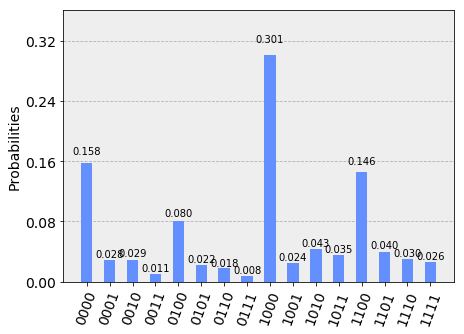

In [13]:
plot_histogram(job.result().get_counts(test))

In [ ]:
# Quantum fidelity

# obtain the final state vector
backend_stvct = Aer.get_backend('statevector_simulator')
job = execute(my_state, backend_stvct)
my_state_psi = job.result().get_statevector(my_state)

# construct state tomography set for measurement of qubits [0, ..., n-1] in the Pauli basis
qubit_set = []
for i in range(0,n) :
    qubit_set.append(i)

my_state_tomo_set = tomo.state_tomography_set(qubit_set) # default value for meas_basis ='Pauli'.

# add the state tomography measurement circuits to the Quantum Program
my_state_tomo_circuits = tomo.create_tomography_circuits(my_state, qr, cr, my_state_tomo_set)

#Choose the backend
backend_tomo = Aer.get_backend('qasm_simulator') # for remaining local
#backend_tomo = least_busy(IBMQ.backends(operational=True, simulator=False)) # for using a real device

# take 1024 shots for each measurement basis
# note: reduce this number for larger number of qubits
shots = 1024

# run the experiment
my_state_job = execute(my_state_tomo_circuits, backend_tomo, shots=shots)
print(my_state_job.status)
my_state_tomo_result = my_state_job.result()
print(my_state_tomo_result)

# extract tomography data from results
my_state_tomo_data = tomo.tomography_data(my_state_tomo_result, my_state.name, my_state_tomo_set)

# reconstruct experimentally measured density matrix 
rho_fit = tomo.fit_tomography_data(my_state_tomo_data)

# calculate fidelity of fitted state:
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('my state',n, '- qubit on', backend_tomo, "N=", shots,time_exp)
F_fit = state_fidelity(rho_fit, my_state_psi)
print('Fidelity with ideal state')
print('F =', F_fit)

### Results: ###

The following results were obtained on the ibmqx4 using 1024 shots in each experiment:

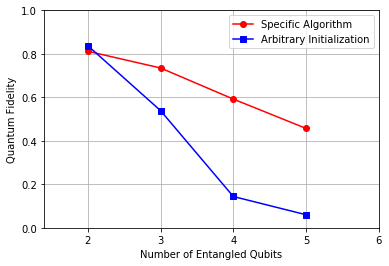

In [14]:
plt.xlabel('Number of Entangled Qubits')
plt.ylabel('Quantum Fidelity')
plt.axis([1.4, 6, 0, 1])
plt.grid()
plt.plot([2,3,4,5], [0.812,0.735,0.592,0.457], 'ro-', label="Specific Algorithm")
plt.plot([2,3,4,5], [0.838,0.539,0.144,0.060], 'bs-', label="Arbitrary Initialization")
plt.legend()
plt.show()

### Concluding remark:


The efficiency of the more compact specific algorithm as a deterministic $ |W_{n}\rangle$ production tool, when estimated from the quantum fidelity, is clearly related to the linear progression of the number of required gates when n increases. On the other hand, the arbitrary initialization requires a number of gate increasing geometrically.
This can be appreciated by looking at the qasm source and the circuit drawings of the respective circuits. 

### References:

[1] Dür, W., Vidal, G., & Cirac, J. I. (2000). Three qubits can be entangled in two inequivalent ways. Physical Review A, 62(6), 062314. 

[2] Diker, F. (2016). Deterministic construction of arbitrary W states with quadratically increasing number of two-qubit gates. arXiv preprint arXiv:1606.09290
